In [2]:
#|default_exp conv

In [3]:
# Install nbdev
# !pip uninstall nbdev
!pip install nbdev

from google.colab import drive
drive.mount('/content/drive')



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.3 MB/s eta 0:00:00
Mounted at /content/drive


In [4]:
!rm -fr *.jpg

In [5]:
# Install the required modules to run this notebook

# Uninstall current version of torch and related packages and install teh correct version to build mini.ai module in the next step
#!pip uninstall -y torch torchvision torchaudio torchtext fastai torchdata
!pip install torch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 torchtext==0.14.1 fastai==2.7.11
!pip install torchdata==0.5.1
!pip install nbdev


# Install the miniai module
#!pip install -Uqq git+https://github.com/fastai/course22p2
#!pip install -Uqq git+https://github.com/georgevetticaden/course22p2
# Instead of installing  mini.ai from my forked repok, lets install it directly from dive which is there from doing a git checkout
!pip install -Uqq /content/drive/MyDrive/Git/course22p2/

# To view references to images/... in this notebook have to cd into the directory where this notebooks is.
#%cd drive/MyDrive/Git
%cd /content/drive/MyDrive/Git/course22p2/nbs



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 586.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.8/232.8 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 57.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu121
    Uninstalling torch-2.1.0+cu121:
      Successfully uninstalled torch-2.1.0+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.16.0+cu121
    Un

# Convolutions

In [6]:
#|export
import torch
from torch import nn

from torch.utils.data import default_collate
from typing import Mapping

from miniai.training import *
from miniai.datasets import *

In [7]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
import pandas as pd,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor

from torch.utils.data import DataLoader
from typing import Mapping

In [8]:
mpl.rcParams['image.cmap'] = 'gray'

In [9]:
# Download the MNIST Data if it doesn't exist

MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'

path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'


from urllib.request import urlretrieve
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)


with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

# MNIST data where training dataset into two tensors for the images (x_train) which are flattened as a single vector row and the labels which are the integers (y_train)
assert isinstance(x_train, torch.Tensor)
assert x_train.shape == torch.Size([50000, 784])

In the context of an image, a feature is a visually distinctive attribute. For example, the number 7 is characterized by a horizontal edge near the top of the digit, and a top-right to bottom-left diagonal edge underneath that.

It turns out that finding the edges in an image is a very common task in computer vision, and is surprisingly straightforward. To do it, we use a *convolution*. A convolution requires nothing more than multiplication, and addition.

### Understanding the Convolution Equations

To explain the math behind convolutions, fast.ai student Matt Kleinsmith came up with the very clever idea of showing [CNNs from different viewpoints](https://medium.com/impactai/cnns-from-different-viewpoints-fab7f52d159c).

Here's the input:

In [10]:
%%html
<img alt="The image" width="75" src="/nbextensions/att_00032.png">



Here's our kernel:

In [11]:
%%html
<img alt="The kernel" width="55" src="/nbextensions/att_00033.png">

Since the filter fits in the image four times, we have four results:

In [12]:
%%html
<img alt="The activations" width="52" src="/nbextensions/att_00034.png">

In [13]:
%%html

<img alt="Applying the kernel" width="366" caption="Applying the kernel" id="apply_kernel" src="/nbextensions/att_00035.png">

In [14]:
%%html
<img alt="The equation" width="436" caption="The equation" id="eq_view" src=" /nbextensions/att_00036.png">

In [15]:
x_imgs = x_train.view(-1,28,28)
xv_imgs = x_valid.view(-1,28,28)

In [16]:
mpl.rcParams['figure.dpi'] = 30

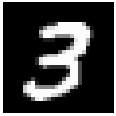

In [17]:
im3 = x_imgs[7]
show_image(im3);

In [18]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

We're going to call this our kernel (because that's what fancy computer vision researchers call these).

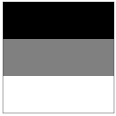

In [19]:
show_image(top_edge, noframe=False);

The filter will take any window of size 3×3 in our images, and if we name the pixel values like this:

$$\begin{matrix} a1 & a2 & a3 \\ a4 & a5 & a6 \\ a7 & a8 & a9 \end{matrix}$$

it will return $-a1-a2-a3+a7+a8+a9$.

In [20]:
df = pd.DataFrame(im3[:13,:23])
df.style.format(precision=2).set_properties(**{'font-size':'7pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03


In [21]:
(im3[3:6,14:17] * top_edge).sum()

tensor(2.9727)

In [22]:
(im3[7:10,14:17] * top_edge).sum()

tensor(-2.9570)

In [23]:
def apply_kernel(row, col, kernel): return (im3[row-1:row+2,col-1:col+2] * kernel).sum()

In [24]:
apply_kernel(4,15,top_edge)

tensor(2.9727)

<img src="images/chapter9_nopadconv.svg" id="nopad_conv" caption="Applying a kernel across a grid" alt="Applying a kernel across a grid" width="400">

In [25]:
[[(i,j) for j in range(5)] for i in range(5)]

[[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)],
 [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 0), (3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]]

In [26]:
inner_list_comprehension = [i for i in range(5)]
inner_list_comprehension

# outer_list_comprehension = [(i,j) for j in range(5) for i in inner_list_comprehension]
# outer_list_comprehension

[0, 1, 2, 3, 4]

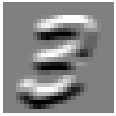

In [27]:
rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])
show_image(top_edge3);
assert im3.shape == torch.Size([28, 28])
assert top_edge3.shape == torch.Size([26, 26])

In [28]:
left_edge = tensor([[-1,0,1],
                    [-1,0,1],
                    [-1,0,1]]).float()

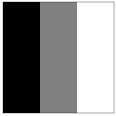

In [29]:
show_image(left_edge, noframe=False);

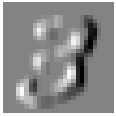

In [30]:
left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])
show_image(left_edge3);

<img alt="Result of applying a 3×3 kernel to a 4×4 image" width="782" caption="Result of applying a 3×3 kernel to a 4×4 image (courtesy of Vincent Dumoulin and Francesco Visin)" id="three_ex_four_conv" src="images/att_00028.png">

### Convolutions in PyTorch

In [31]:
import torch.nn.functional as F
import torch

What to do if you have [2 months to complete your thesis](https://github.com/Yangqing/caffe/wiki/Convolution-in-Caffe:-a-memo)? Use [im2col](https://hal.inria.fr/inria-00112631/).

![image.png](attachment:image.png)

Here's a sample [numpy implementation](https://github.com/3outeille/CNNumpy/blob/5394f13e7ed67a808a3e39fd381f168825d65ff5/src/fast/utils.py#L360).

In [32]:
im3.shape # ([28, 28])
inp = im3[None,None,:,:].float()
inp_unf = F.unfold(inp, (3,3))[0]
inp_unf.shape # torch.Size([9, 676])


torch.Size([9, 676])

In [33]:
left_edge.shape # [3, 3]
w = left_edge.view(-1)
w.shape # torch.Size([9])


torch.Size([9])

In [34]:
out_unf = w@inp_unf
out_unf.shape # torch.Size([676])

torch.Size([676])

torch.Size([26, 26])

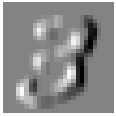

In [35]:
out_unf.shape # [676]
out = out_unf.view(26,26)
show_image(out);
out.shape # [26, 26]

In [36]:
%timeit -n 1 tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng]);

37.2 ms ± 9.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
%timeit -n 100 (w@F.unfold(inp, (3,3))[0]).view(26,26);

262 µs ± 119 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
%timeit -n 100 F.conv2d(inp, left_edge[None,None])

29 µs ± 4.55 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
#F.conv2d requires input image to be a 4-dim tensor (batch_size, # of input channels, imgH, imgW)
im3.shape # ([28, 28])
inp_4_dim = im3[None,None,:,:].float()
inp_4_dim.shape #[1, 1, 28, 28])

#F.conv2d requires filter to be a a 4-dim tensor: (# of filters, # of input channels, kH, kW)
left_edge.shape # [3, 3]
left_edge_4_dim = left_edge[None, None]
left_edge_4_dim.shape # ([1, 1, 3, 3])

out = F.conv2d(inp_4_dim, left_edge_4_dim)
out.shape # torch.Size([1, 1, 26, 26])


torch.Size([1, 1, 26, 26])

In [40]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()

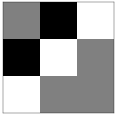

In [41]:
show_image(diag1_edge, noframe=False);

In [42]:
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

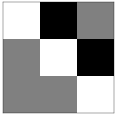

In [43]:
show_image(diag2_edge, noframe=False);

In [44]:
#F.conv2d requires input image to be a 4-dim tensor (batch_size, # of input channels, imgH, imgW)
xb = x_imgs[:16][:,None]
xb.shape # torch.Size([16, 1, 28, 28])

torch.Size([16, 1, 28, 28])

In [45]:
#F.conv2d requires filter to be a a 4-dim tensor: (# of filters, # of input channels, kH, kW)
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])[:,None]
edge_kernels.shape #torch.Size([4, 1, 3, 3])

torch.Size([4, 1, 3, 3])

In [46]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape # torch.Size([16, 4, 26, 26])

torch.Size([16, 4, 26, 26])

The output shape shows we gave 64 images in the mini-batch, 4 kernels, and 26×26 edge maps (we started with 28×28 images, but lost one pixel from each side as discussed earlier). We can see we get the same results as when we did this manually:

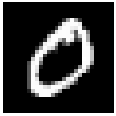

In [47]:
# grab the first image of our batch of 16 (xb = x_imgs[:16][:,None])
img0 = xb[1,0]
img0.shape #[28, 28])
show_image(img0);

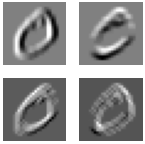

In [48]:
# Show the 4 feature maps for the first image we created using the 4 filter convolution
show_images([batch_features[1,i] for i in range(4)])

### Strides and Padding

With appropriate padding, we can ensure that the output activation map is the same size as the original image.

<img src="images/chapter9_padconv.svg" id="pad_conv" caption="A convolution with padding" alt="A convolution with padding" width="600">

With a 5×5 input, 4×4 kernel, and 2 pixels of padding, we end up with a 6×6 activation map.

<img alt="A 4×4 kernel with 5×5 input and 2 pixels of padding" width="783" caption="A 4×4 kernel with 5×5 input and 2 pixels of padding (courtesy of Vincent Dumoulin and Francesco Visin)" id="four_by_five_conv" src="images/att_00029.png">

If we add a kernel of size `ks` by `ks` (with `ks` an odd number), the necessary padding on each side to keep the same shape is `ks//2`.

We could move over two pixels after each kernel application. This is known as a *stride-2* convolution.

<img alt="A 3×3 kernel with 5×5 input, stride-2 convolution, and 1 pixel of padding" width="774" caption="A 3×3 kernel with 5×5 input, stride-2 convolution, and 1 pixel of padding (courtesy of Vincent Dumoulin and Francesco Visin)" id="three_by_five_conv" src="images/att_00030.png">

## Creating the CNN

In [49]:
n,m = x_train.shape # [50000, 784]
c = y_train.max()+1
nh = 50

In [50]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

39760

In [51]:
broken_cnn = nn.Sequential(
    nn.Conv2d(1,30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,10, kernel_size=3, padding=1)
)

In [52]:
broken_cnn(xb).shape

torch.Size([16, 10, 28, 28])

In [53]:
#|export
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

Refactoring parts of your neural networks like this makes it much less likely you'll get errors due to inconsistencies in your architectures, and makes it more obvious to the reader which parts of your layers are actually changing.

In [54]:
simple_cnn = nn.Sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,16),           #2x2
    conv(16,10, act=False), #1x1
    nn.Flatten(),
)

# One key difference between CNN and MLP
#is that CNN are faster since it is not a fully connected network and hence has lot less parameters
count_parameters(simple_cnn) # 5274


5274

In [55]:
# xb.shape # torch.Size([16, 1, 28, 28])
simple_cnn(xb).shape #torch.Size([16, 10])

torch.Size([16, 10])

In [56]:
# Create DataSet for Validation and Training
# first reshape our training dataset tensor from [50K, 784] to [50K,  1, 28, 28]

x_train.shape # [50000, 784]
x_imgs = x_train.view(-1,1,28,28)
xv_imgs = x_valid.view(-1,1,28,28)
train_ds,valid_ds = Dataset(x_imgs, y_train),Dataset(xv_imgs, y_valid)



In [57]:
#|export
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def collate_device(b): return to_device(default_collate(b))

def_device

'cpu'

In [63]:
from torch import optim

bs = 256
lr = 0.4
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs, collate_fn=collate_device)

first_batch = next(iter(train_dl))
first_batch[0].shape # torch.Size([256, 1, 28, 28])

torch.Size([256, 1, 28, 28])

In [57]:
from torch import optim

bs = 256
lr = 0.4
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs, collate_fn=collate_device)
opt = optim.SGD(simple_cnn.parameters(), lr=lr)

In [58]:
%time loss,acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 0.735308436012268 0.7513000002861023
1 0.17583274145126343 0.9478000001907348
2 0.12089903867244721 0.9637999994277954
3 0.11181189076900482 0.9675000007629394
4 0.10704447407722473 0.9663999993324279
CPU times: user 21.5 s, sys: 38.2 ms, total: 21.5 s
Wall time: 29.4 s


In [59]:
opt = optim.SGD(simple_cnn.parameters(), lr=lr/4)
%time loss,acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 0.08517782815694809 0.9751999995231628
1 0.08075385122299195 0.9760999996185302
2 0.07942137690782547 0.9774999996185303
3 0.08187552368640899 0.9763999996185303
4 0.07946957248449325 0.9773999995231628
CPU times: user 17.5 s, sys: 27.7 ms, total: 17.5 s
Wall time: 17.7 s


### Understanding Convolution Arithmetic

In an input of size `64x1x28x28` the axes are `batch,channel,height,width`. This is often represented as `NCHW` (where `N` refers to batch size). Tensorflow, on the other hand, uses `NHWC` axis order (aka "channels-last"). Channels-last is faster for many models, so recently it's become more common to see this as an option in PyTorch too.

We have 1 input channel, 4 output channels, and a 3×3 kernel.

In [60]:
simple_cnn[0][0]

Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

In [61]:
conv1 = simple_cnn[0][0]
conv1.weight.shape

torch.Size([4, 1, 3, 3])

In [62]:
conv1.bias.shape

torch.Size([4])

The *receptive field* is the area of an image that is involved in the calculation of a layer. *conv-example.xlsx* shows the calculation of two stride-2 convolutional layers using an MNIST digit. Here's what we see if we click on one of the cells in the *conv2* section, which shows the output of the second convolutional layer, and click *trace precedents*.

<img alt="Immediate precedents of conv2 layer" width="308" caption="Immediate precedents of Conv2 layer" id="preced1" src="images/att_00068.png">

The blue highlighted cells are its *precedents*—that is, the cells used to calculate its value. These cells are the corresponding 3×3 area of cells from the input layer (on the left), and the cells from the filter (on the right). Click *trace precedents* again:

<img alt="Secondary precedents of conv2 layer" width="601" caption="Secondary precedents of Conv2 layer" id="preced2" src="images/att_00069.png">

In this example, we have just two convolutional layers. We can see that a 7×7 area of cells in the input layer is used to calculate the single green cell in the Conv2 layer. This is the *receptive field*

The deeper we are in the network (specifically, the more stride-2 convs we have before a layer), the larger the receptive field for an activation in that layer.

## Color Images

A colour picture is a rank-3 tensor:

In [63]:
from torchvision.io import read_image

In [65]:
im = read_image('/content/drive/MyDrive/Git/course22p2/nbs/images/grizzly.jpg')
im.shape

torch.Size([3, 1000, 846])

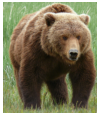

In [66]:
show_image(im.permute(1,2,0));

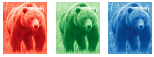

In [67]:
_,axs = plt.subplots(1,3)
for bear,ax,color in zip(im,axs,('Reds','Greens','Blues')): show_image(255-bear, ax=ax, cmap=color)

<img src="images/chapter9_rgbconv.svg" id="rgbconv" caption="Convolution over an RGB image" alt="Convolution over an RGB image" width="550">

These are then all added together, to produce a single number, for each grid location, for each output feature.

<img src="images/chapter9_rgb_conv_stack.svg" id="rgbconv2" caption="Adding the RGB filters" alt="Adding the RGB filters" width="500">

We have `ch_out` filters like this, so in the end, the result of our convolutional layer will be a batch of images with `ch_out` channels.

## Export -

In [68]:
import nbdev; nbdev.nbdev_export()